In [1]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# Load data and utils

In [2]:
transform = transforms.Compose([
    transforms.ToTensor()
])

train_data = datasets.CIFAR10(root = "./data", train = True, download = True, transform = transform)
train_loader = DataLoader(dataset = train_data, batch_size = 32, shuffle = True)

test_data = datasets.CIFAR10(root = "./data", train = False, download = True, transform = transform)
test_loader = DataLoader(dataset = test_data, batch_size = 32, shuffle = False)

100%|██████████| 170498071/170498071 [00:06<00:00, 25465148.02it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


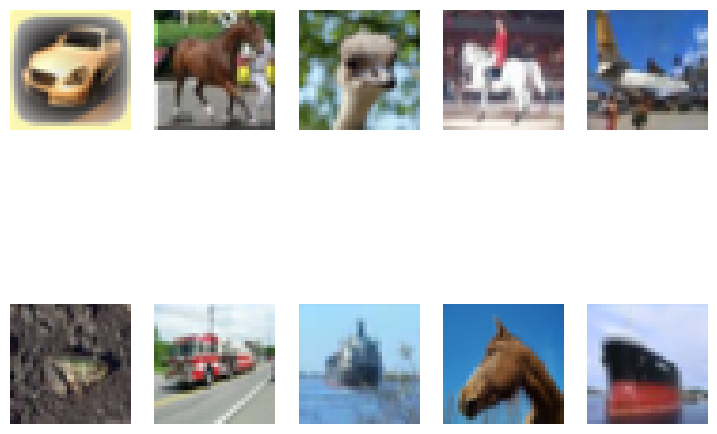

In [3]:
plt.figure(figsize = (9, 7))
def show_img(batch):
    imgs, labels = batch
    for id, img in enumerate(imgs[:10]):
        plt.subplot(2, 5, id + 1)
        plt.axis("off")
        plt.imshow(img.permute(1, 2, 0))
    plt.show()
        
for imgs, labels in train_loader:
    batch = (imgs, labels)
    break

show_img(batch)

# DCGAN

In [4]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.fc = nn.Linear(in_features = 128, out_features = 2048)

        self.deconv1 = nn.ConvTranspose2d(in_channels = 2048, out_channels = 512, kernel_size = 2)
        self.deconv2 = nn.ConvTranspose2d(in_channels = 512, out_channels = 256, kernel_size = 2, stride = 2)
        self.batchnorm2 = nn.BatchNorm2d(256)

        self.deconv3 = nn.ConvTranspose2d(in_channels = 256, out_channels = 128, kernel_size = 2, stride = 2)
        self.deconv4 = nn.ConvTranspose2d(in_channels = 128, out_channels = 64, kernel_size = 2, stride = 2)
        self.batchnorm4 = nn.BatchNorm2d(64)

        self.deconv5 = nn.ConvTranspose2d(in_channels = 64, out_channels = 3, kernel_size = 2, stride = 2)
        self.batchnorm5 = nn.BatchNorm2d(3)

        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.fc(x)
        x = torch.unsqueeze(x, dim = -1)
        x = torch.unsqueeze(x, dim = -1)
        x = self.deconv1(x)
        x = self.deconv2(x)
        x = self.batchnorm2(x)
        x = self.relu(x)

        x = self.deconv3(x)
        x = self.deconv4(x)
        x = self.batchnorm4(x)
        x = self.relu(x)

        x = self.batchnorm5(self.deconv5(x))
        x = nn.Tanh()(x)

        return x
    

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 2, stride = 2)
        self.batchnorm1 = nn.BatchNorm2d(64)

        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 2, stride = 2)
        self.batchnorm2 = nn.BatchNorm2d(128)

        self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 2, stride = 2)
        self.batchnorm3 = nn.BatchNorm2d(256)

        self.conv4 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 2, stride = 2)
        self.batchnorm4 = nn.BatchNorm2d(512)

        self.leakyrelu = nn.LeakyReLU()
        self.fc = nn.Linear(2048, 1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.leakyrelu(x)
        x = self.batchnorm1(x)

        x = self.conv2(x)
        x = self.leakyrelu(x)
        x = self.batchnorm2(x)

        x = self.conv3(x)
        x = self.leakyrelu(x)
        x = self.batchnorm3(x)

        x = self.conv4(x)
        x = self.leakyrelu(x)
        x = self.batchnorm4(x)
        
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        x = nn.Sigmoid()(x)
        return x
    

In [31]:
generator = Generator()
gen_optimizer = optim.Adam(params = generator.parameters(), lr = 0.002)

discriminator = Discriminator()
dis_optimizer = optim.Adam(params = discriminator.parameters(), lr = 0.002)

criterion = nn.BCELoss()
num_epochs = 50


In [32]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

generator.train()
discriminator.train()

G_loss_history = []
D_loss_history = []

for epoch in range(num_epochs):
    for i, (imgs, _) in enumerate(train_loader):
        if i <= 100:
            # discriminator training
            
            imgs = imgs.to(device)
            noise = torch.randn(size = (32, 128)).to(device)
            gen_imgs = generator(noise)
            
            real_labels = torch.ones(size = (32, ), dtype = torch.float32) 
            dis_real = discriminator(imgs)
            real_loss = criterion(dis_real.squeeze(), real_labels)
            
            fake_labels = torch.zeros(size = (32, ), dtype = torch.float32)
            dis_fake = discriminator(gen_imgs.detach())
            fake_loss = criterion(dis_fake.squeeze(), fake_labels)
            
            dis_loss = real_loss + fake_loss
            discriminator.zero_grad()
            dis_loss.backward()
            dis_optimizer.step()

            # generator updated
            gen_labels = discriminator(gen_imgs).squeeze()
            gen_loss = criterion(gen_labels, real_labels)
            generator.zero_grad()
            gen_loss.backward()
            gen_optimizer.step()

            if i % 10 == 0:
                print("Epoch: {}/{}, generator loss: {}, discriminator loss: {}". \
                                                          format(i, epoch, gen_loss.item(), dis_loss.item()))
            G_loss_history.append(gen_loss.item())
            D_loss_history.append(dis_loss.item())
        else:
            break
    print("------------------\n")
            

Epoch: 0/0, generator loss: 5.770816802978516, discriminator loss: 1.455446481704712
Epoch: 10/0, generator loss: 2.9036712646484375, discriminator loss: 1.657997965812683
Epoch: 20/0, generator loss: 4.3843092918396, discriminator loss: 0.7004676461219788
Epoch: 30/0, generator loss: 4.626935958862305, discriminator loss: 1.3782601356506348
Epoch: 40/0, generator loss: 3.211343288421631, discriminator loss: 1.2030936479568481
Epoch: 50/0, generator loss: 3.8908820152282715, discriminator loss: 1.330841302871704
Epoch: 60/0, generator loss: 3.758918523788452, discriminator loss: 0.7004966735839844
Epoch: 70/0, generator loss: 3.334122657775879, discriminator loss: 0.8517661094665527
Epoch: 80/0, generator loss: 2.988355875015259, discriminator loss: 1.1108628511428833
Epoch: 90/0, generator loss: 4.267178058624268, discriminator loss: 0.8832534551620483
Epoch: 100/0, generator loss: 4.0093607902526855, discriminator loss: 1.228036880493164
------------------

Epoch: 0/1, generator loss

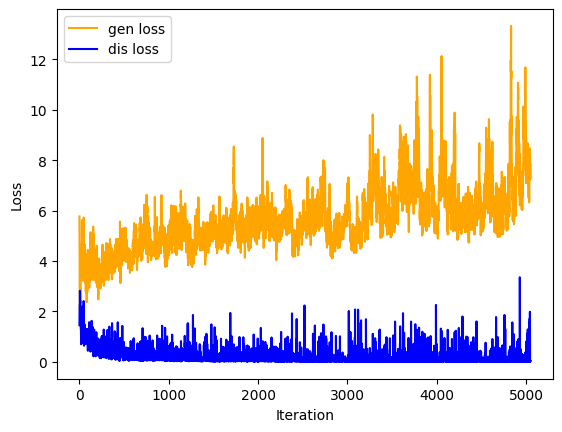

In [33]:
plt.plot(G_loss_history, c = "orange", label = "gen loss")
plt.plot(D_loss_history, c = "blue", label = "dis loss")
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.legend()
plt.show()

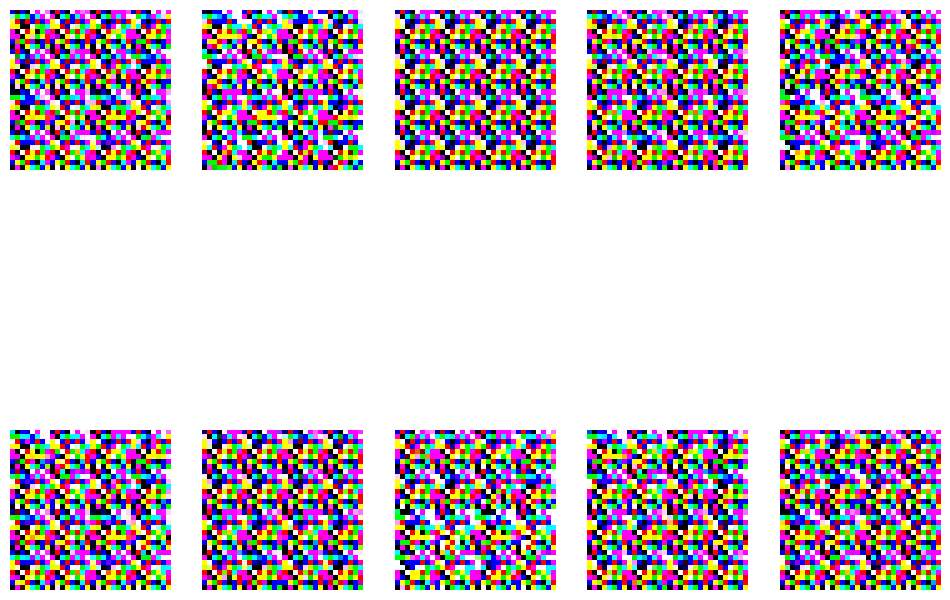

In [34]:
gen_imgs = generator(noise)
plt.figure(figsize = (12, 10))
for id, img in enumerate(gen_imgs[:10]):
    plt.subplot(2, 5, id + 1)
    plt.imshow(img.permute(1, 2, 0).detach().numpy())
    plt.axis("off")